# f-MRI Tumour Classification

In [66]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, LeakyReLU, PReLU
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay

## Get the data

We shall be using a dataset of f-MRI scans of humans with and without brain tumors; they are in the `/data/yes` and `/data/no` directories respectively.

In [3]:
pos_dir = "data/original/yes"
neg_dir = "data/original/no"

pos_imgs = np.array([cv.imread('{0}/{1}'.format(pos_dir, filepath),0) for filepath in os.listdir(pos_dir)])
neg_imgs = np.array([cv.imread('{0}/{1}'.format(neg_dir, filepath),0) for filepath in os.listdir(neg_dir)])

Images are of different sizes, so we will reshape them.

We will find the minimum height and width for all of the images and reshape all images to those dimensions.

In [4]:
min_h = pos_imgs[0].shape[0]
min_w = pos_imgs[0].shape[1]

for img in np.append(pos_imgs, neg_imgs):
    if (img.shape[0] < min_h):
        min_h = img.shape[0]
    if (img.shape[1] < min_w):
        min_w = img.shape[1]

print(f"images to be shaped to ({min_h}, {min_w})")

images to be shaped to (168, 150)


We can now reshape all of the images.

In [5]:
X_pos = np.asarray([cv.resize(img, (min_w, min_h)) for img in pos_imgs])
X_neg = np.asarray([cv.resize(img, (min_w, min_h)) for img in neg_imgs])

print(f"Postivies: {X_pos.shape[0]} * ({X_pos.shape[1]}, {X_pos.shape[2]})")
print(f"Negatives:  {X_neg.shape[0]} * ({X_neg.shape[1]}, {X_neg.shape[2]})")

Postivies: 155 * (168, 150)
Negatives:  98 * (168, 150)


We now have 155 positives and 98 negatives all of dimensions 150x168.

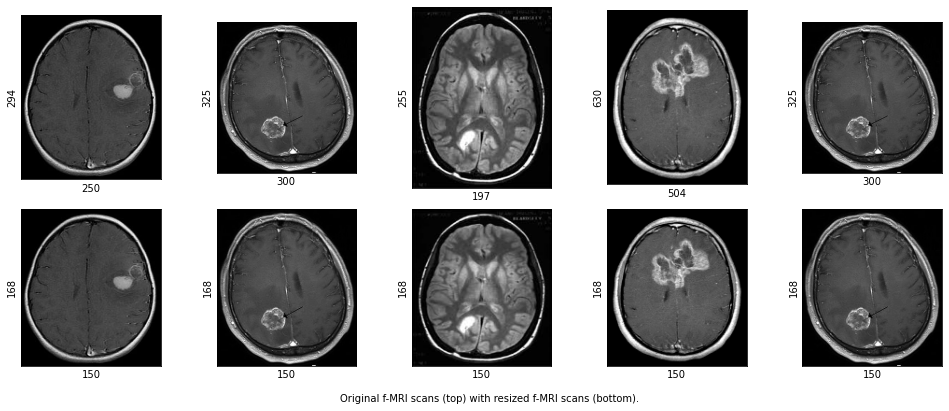

In [6]:
def plot_resized_images(orig_imgs, resized_imgs, title, text, num=5):
    fig = plt.figure(figsize=(20, 12))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    indices = np.random.choice(len(orig_imgs), num)
    for i, ind in enumerate(indices):
        ax = fig.add_subplot(1, num+1, i+1)
        ax.imshow(orig_imgs[ind], cmap='gray')
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.set_xlabel(orig_imgs[ind].shape[1])
        ax.set_ylabel(orig_imgs[ind].shape[0])
    for i, ind in enumerate(indices):
        ax = fig.add_subplot(2, num+1, i+num+2)
        ax.imshow(resized_imgs[ind], cmap='gray')
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.set_xlabel(resized_imgs[ind].shape[1])
        ax.set_ylabel(resized_imgs[ind].shape[0])
    fig.text(0.45, 0.15, text, ha="center")

title = "f-MRI Scans of Brain Tumor Patients"
text = "Original f-MRI scans (top) with resized f-MRI scans (bottom)."
plot_resized_images(pos_imgs, X_pos, title, text)

We shall combine the positive and negative samples into one feature array `X`. We shall also create a label array `y` to retain class information.

In [7]:
X = np.vstack((X_pos, X_neg))
print(f"{X.shape[0]} * ({X.shape[2]}, {X.shape[1]}) images\n")

y_pos = np.ones((X_pos.shape[0]))
y_neg = np.zeros((X_neg.shape[0]))
y = np.append(y_pos, y_neg)
print(f"{y.shape[0]} labels - {y_pos.size} positive, {y_neg.size} negative")

253 * (150, 168) images

253 labels - 155 positive, 98 negative


The data is now combined, but we've done it in a way where all positives are followed by all negatives. It is a good idea to shuffle them so it does not decide all images are postive in the first half of training. `sklearn.utils.shuffle` does this, but we also wish to create training and test sets and `sklearn.model_selection.train_test_split` sets its `shuffle` parameter to `True` by default which will do the same thing. We shall also take a small validation set from the training set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(f"train size: {X_train.shape[0]}, validation size: {X_val.shape[0]}, test size: {X_test.shape[0]}")

train size: 181, validation size: 21, test size: 51


The data is now ready for an initial machine learning model.

Based on performance there are some other preprocessing steps that may help, such as:
- creating a flipped version of each image to increase training set size
- applying a small Gaussian blur kernel to each image
- image brightness could be normalised across the images
- some images have small labels in the corners which could be removed
- removing positive samples so there is an equal number of classes

## Image batching

Although we have done most of the preprocessing already, Keras has a built in method for loading the images from the directory in batches whilst applying the same preprocessing steps as above (and more).

To do this we will need to organise the iamges into the data directory in a way specified by `tensorflow.keras.preprocessing.image_dataset_from_directory`:

```
project/
    data/
        train_train/
            pos_train/
                ...
            neg_train/
                ...
         train_val/
            pos_val/
                ...
            neg_val/
                ...
        test/
            test/
                ...
            test.csv
```

We will load the original data back in ready to be aranged into this structure.

In [51]:
pos_dir = "data/original/yes"
neg_dir = "data/original/no"

pos_imgs = [cv.imread('{0}/{1}'.format(pos_dir, filepath),0) for filepath in os.listdir(pos_dir)]
neg_imgs = [cv.imread('{0}/{1}'.format(neg_dir, filepath),0) for filepath in os.listdir(neg_dir)]

We shall combine them and make a feature column as before.

In [52]:
X = pos_imgs + neg_imgs

y_pos = np.ones((len(pos_imgs)))
y_neg = np.zeros((len(neg_imgs)))
y = np.append(y_pos, y_neg)

print(f"{y.shape[0]} images - {len(y_pos)} positive, {len(y_neg)} negative")

253 images - 155 positive, 98 negative


Now we can use `test_train_split` to get our training, validation and testing sets.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

print(f"{len(X_train)} train, {len(X_val)} validation, {len(X_test)} test images")

181 train, 21 validation, 51 test images


Now we can put them into the correct directories, but first we will need to make sure they exist.

If they do exist, we will remove the contents of the directory as to not leak test data into the training directory.

In [101]:
pos_train_dir = "data/train/pos_train/"
neg_train_dir = "data/train/neg_train/"
pos_val_dir = "data/val/pos_val/"
neg_val_dir = "data/val/neg_val/"
pos_test_dir = "data/test/pos_test/"
neg_test_dir = "data/test/neg_test/"

cwd = os.getcwd()
for dir in [pos_train_dir, neg_train_dir, pos_val_dir, neg_val_dir, pos_test_dir, neg_test_dir]:
    full_dir = os.path.join(cwd, dir)
    if not os.path.isdir(full_dir):    
        os.makedirs(full_dir)
    else:
        for filepath in os.listdir(full_dir):
            os.remove(os.path.join(full_dir, filepath))

Now we can write the train and validation images to the correct directories.

In [102]:
dirs = [(pos_train_dir, neg_train_dir, X_train, y_train),
        (pos_val_dir, neg_val_dir, X_val, y_val),
        (pos_test_dir, neg_test_dir, X_test, y_test)]

for (pos_dir, neg_dir, set_X, set_y) in dirs:
    pos_i, neg_i = 0, 0
    for (img, label) in zip(set_X, set_y):
        if (label == 1):
            filename = pos_dir + "tumour_" + str(pos_i) + ".jpg"
            cv.imwrite(filename, img)
            pos_i += 1
        else:
            filename = neg_dir + "none_" + str(neg_i) + ".jpg"
            cv.imwrite(filename, img)
            neg_i += 1

We shall also create a safe test safe where positive and negative samples are in the same directory. We shall create a csv file to track the labels.

In [103]:
safe_test_dir = "data/safe_test/test/"

full_dir = os.path.join(cwd, safe_test_dir)
if not os.path.isdir(full_dir):    
    os.makedirs(full_dir)
else:
    for filepath in os.listdir(full_dir):
        os.remove(os.path.join(full_dir, filepath))

for i, img in enumerate(X_test):
    filename = safe_test_dir + "test" + str(i) + ".jpg"
    cv.imwrite(filename, img)

test_csv_path = os.path.join(os.getcwd(), "data/safe_test/test.csv")
np.savetxt(test_csv_path, y_test, delimiter=",")

- Images are now seperated into training, validation and testing sets.
- They have been put into seperate subdirectories and further seperated by class.
- Test data is in a combined directory where `test.csv` contains class labels.
- Data can now be fed into a CNN using `ImageDataGenerator`.

## Tumour Detection

We shall create a CNN model with Keras to perform our classification task.

### Data generator

First we shall create an image data generator to load and preprocess images in bathces for our CNN.

In [98]:
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("data/train",
                                                    target_size=(150, 150),
                                                    batch_size=batch_size,
                                                    class_mode="binary",
                                                    color_mode="grayscale") 

val_generator = val_datagen.flow_from_directory("data/val",
                                                target_size=(150, 150),
                                                batch_size=batch_size,
                                                class_mode="binary",
                                                color_mode="grayscale")


Found 181 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


### CNN model

We will use a few convolutional layers of increasing size with 3x3 kernels. The output shall flatten to a single node with sigmoid activation as this is a binary classification task (positive or negative).

In [72]:
model = Sequential()

# input layer
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=(150, 150, 1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

# output layer
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 64)      640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)      

We shall compile the model with binary cross-entropy loss and use Adam optimisation. We shall also add the `EarlyStopping` callback to allow training to stop early if it is not progressing.

In [73]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)
callbacks = [early_stopping_cb]

Now we can fit the model to the training data and use the validation set to get an idea of how it is generalising during training.

In [77]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=val_generator,
                    callbacks=callbacks)

model.save('models/cnnmodel')

Epoch 1/50
12/12 [==============================] - 6s 475ms/step - loss: 0.6505 - accuracy: 0.6519 - val_loss: 0.8450 - val_accuracy: 0.3810
Epoch 2/50
12/12 [==============================] - 5s 439ms/step - loss: 0.6096 - accuracy: 0.6851 - val_loss: 0.5072 - val_accuracy: 0.8095
Epoch 3/50
12/12 [==============================] - 5s 444ms/step - loss: 0.5425 - accuracy: 0.7569 - val_loss: 0.5183 - val_accuracy: 0.7619
Epoch 4/50
12/12 [==============================] - 5s 434ms/step - loss: 0.4547 - accuracy: 0.7956 - val_loss: 0.6088 - val_accuracy: 0.8095
Epoch 5/50
12/12 [==============================] - 5s 436ms/step - loss: 0.4110 - accuracy: 0.8177 - val_loss: 0.7770 - val_accuracy: 0.6667
Epoch 6/50
12/12 [==============================] - 5s 426ms/step - loss: 0.3694 - accuracy: 0.8508 - val_loss: 0.9595 - val_accuracy: 0.6667
Epoch 7/50
12/12 [==============================] - 5s 424ms/step - loss: 0.4036 - accuracy: 0.8508 - val_loss: 0.9098 - val_accuracy: 0.6667
INFO:t

## Model evaluation

Now the model has been trained we can evaluate its performance on the test set.

We shall create a generator for the test set.

In [104]:
# test_csv_path = os.path.join(os.getcwd(), "data/test/test.csv")
# np.genfromtxt(test_csv_path, delimiter=",")

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory("data/test",
                                                  target_size=(150, 150),
                                                  batch_size=batch_size,
                                                  class_mode="binary",
                                                  color_mode="grayscale")

Found 51 images belonging to 2 classes.


Now we can use the `evaluate` method to check predictions against the real labels (inferred from subdirectory structure).

In [111]:
model.evaluate(test_generator)

4/4 [==============================] - 0s 65ms/step - loss: 0.4736 - accuracy: 0.8627


[0.47362616658210754, 0.8627451062202454]

The model acheives an accuracy of 86%